In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.utils import resample
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
from joblib import Parallel, delayed

In [205]:
# Load data
data = pd.read_csv("/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/signatures.csv")
studies = pd.read_csv("/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/palm/simple_zerocon/df_studies.csv")

# Exclude studies with insufficient data
exclude_studies = ["kessner", "ruetgen", "wager04a_princeton", "wager04b_michigan"]
studies = studies[~studies['study_ID'].isin(exclude_studies)]

data['plc_induction'] = data['Conditioning'].astype('category').cat.codes
data['Rating_diff'] = -1*data['Rating_diff']   # higher score stronger placebo
# center explanatory variables
data['Rating_pain_ctr'] = data['Rating_pain_ctr'] - data['Rating_pain_ctr'].mean()
data['Age'] = data['Age'] - data['Age'].mean()
data['Male'] = data['Male'] - data['Male'].mean()

# Display column names (optional)
# print(data.columns)
# print(studies.columns)

In [206]:
data

,Unnamed: 0,Study_ID,Sub_ID,Male,Age,NPS_pain_ctr,Rating_pain_ctr,Rating_diff,Conditioning,TR,...,fear_vicarious_pain_zhou_2020,negative_affect_common_ceko_2022,negative_affect_mechanical_ceko_2022,negative_affect_sound_ceko_2022,negative_affect_thermal_ceko_2022,negative_affect_visual_ceko_2022,vifs_fear_picture_zhou_2021,basic_sexual_image_vanthof_2021,brs_reward_monetary_speer_2022,plc_induction
0,0,atlas,atlas_remi1022s1,-0.169403,-1.635208,-14.056126,-5.653458,2.664155,suggestions,2000,...,0.016313,0.037931,0.001628,0.037247,0.001329,0.040771,0.047013,-0.040887,0.041096,0
1,1,atlas,atlas_remi1056s1,-0.169403,-1.635208,-17.798976,22.070501,20.196549,suggestions,2000,...,0.023691,-0.037930,-0.007684,-0.009602,-0.017617,-0.025331,0.037159,0.002307,-0.041179,0
2,2,atlas,atlas_remi1090s2,-0.169403,-1.635208,2.168433,37.675992,14.623164,suggestions,2000,...,0.072299,0.017802,-0.013074,-0.031132,0.043191,-0.007662,0.026102,0.008086,-0.067313,0
3,3,atlas,atlas_remi1126,-0.169403,-1.635208,7.489692,-9.352638,-11.918164,suggestions,2000,...,0.004046,-0.026222,0.012254,-0.004010,-0.019002,-0.028841,-0.052546,0.066338,0.019311,0
4,4,atlas,atlas_remi1262,-0.169403,-1.635208,0.628170,-10.284073,17.996207,suggestions,2000,...,-0.005427,-0.008387,0.037694,-0.020480,-0.021717,0.004830,0.029516,-0.001712,0.027564,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,404,zeidan,zeidan_088,0.354407,13.664792,-14181.082538,-4.676903,-2.000000,suggestions & conditioning,4000,...,-0.041332,0.004074,0.024568,0.007249,-0.026077,0.030768,0.019113,-0.046716,-0.058592,1
405,405,zeidan,zeidan_095,0.354407,1.664792,51758.838562,-12.676903,4.000000,suggestions & conditioning,4000,...,-0.019907,-0.012158,-0.017015,-0.053137,0.024225,-0.000572,0.006161,-0.015371,0.018483,1
406,406,zeidan,zeidan_097,-0.645593,-2.335208,77748.911669,-5.426903,-4.500000,suggestions & conditioning,4000,...,0.004466,-0.010598,-0.060007,-0.001854,0.039077,-0.034849,-0.009718,-0.009351,-0.007400,1
407,407,zeidan,zeidan_098,0.354407,9.664792,62130.045615,-30.676903,8.000000,suggestions & conditioning,4000,...,0.004821,0.021077,0.087820,-0.016302,-0.038430,0.041020,0.039214,-0.015043,-0.035104,1


In [207]:
mean_inst = data[data['Conditioning'] == "suggestions"]['Rating_diff'].mean()
mean_cond = data[data['Conditioning'] == "suggestions & conditioning"]['Rating_diff'].mean()

print(f'Mean (INST): {mean_inst}')
print(f'Mean (COND-INST): {mean_cond}')
print(f'Difference: {mean_cond - mean_inst}')

Mean (INST): 9.17965372196802
Mean (COND-INST): 12.225893552576416
Difference: 3.046239830608396


In [208]:
from statsmodels import api as sm
# Prepare data for non-formula style regression
X = data[['plc_induction', 'Rating_pain_ctr', 'Age', 'Male']].copy()
# Interaction term
#X['plc_induction_X_Rating_pain_ctr'] = X['plc_induction'] * X['Rating_pain_ctr']
y = data['Rating_diff']
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit linear model
model = sm.OLS(y, X).fit()
print(model.summary())
print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     12.68
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           9.97e-10
Time:                        10:56:17   Log-Likelihood:                -1713.0
No. Observations:                 409   AIC:                             3436.
Df Residuals:                     404   BIC:                             3456.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.3230      1.362     

In [209]:
from statsmodels import api as sm
# Prepare data for non-formula style regression

X = data[['plc_induction', 'Rating_pain_ctr', 'Age', 'Male']].copy()
# Interaction term
X['plc_induction_X_Rating_pain_ctr'] = X['plc_induction'] * X['Rating_pain_ctr']
y = data['Rating_diff']
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit linear model
model = sm.OLS(y, X).fit()
print(model.summary())
print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     11.74
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           1.31e-10
Time:                        10:56:18   Log-Likelihood:                -1709.4
No. Observations:                 409   AIC:                             3431.
Df Residuals:                     403   BIC:                             3455.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_41541/629020806.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')


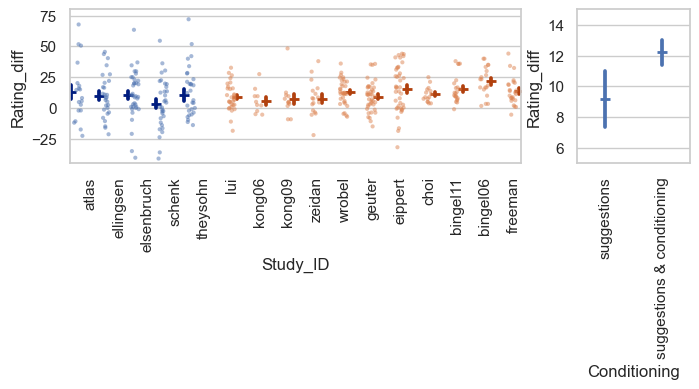

In [210]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 2), gridspec_kw={'width_ratios': [4, 1]})
# Plot data with jitter and summary statistics
sns.stripplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), jitter=0.3, alpha=0.5, dodge=True, legend=False, ax=axes[0], size=3)
sns.pointplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), dodge=0.9, palette="dark", markers="_", errorbar="se", legend=False, linestyle='none', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
axes[0].set_ylim(-45, 80)

#sns.violinplot(x='Conditioning', y='Rating_diff', data=data, inner='quartile', ax=axes[1])
#sns.boxplot(x='Conditioning', y='Rating_diff', data=data, ax=axes[1])
sns.pointplot(x='Conditioning', y='Rating_diff', data=data, markers="_", errorbar="se", linestyle='none', ax=axes[1])

plt.axhline(0, color='gray', linestyle='dashed', alpha=0.5)
plt.xticks(rotation=90)
plt.ylim(5, 15)
#plt.legend(title='Conditioning')
plt.savefig('../fig/behav_pointplot.pdf')
plt.show()

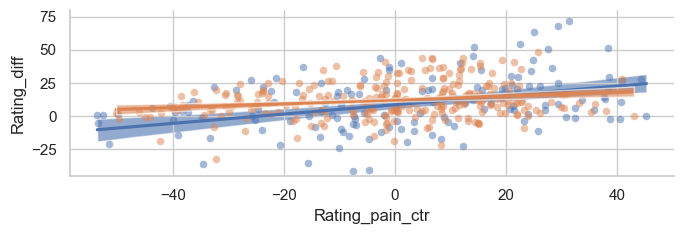

In [211]:
sns.set(style="whitegrid")

# Plot data with jitter and summary statistics
sns.lmplot(x='Rating_pain_ctr', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), 
           scatter_kws={'alpha':0.5, 's':30, 'linewidths': 0}, 
           line_kws={'alpha': 1},
           legend=False, height=2.5, aspect=2.8)
plt.setp(plt.gca().collections[1], alpha=0.6, zorder=-10)
plt.setp(plt.gca().collections[3], alpha=0.6, zorder=10)
plt.ylim(-45, 80)
plt.savefig('../fig/behav_interaction.pdf')